In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# ============================ Settings ============================
BASE_GRD = '/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/GRD'
BASE_SLC = '/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/SLC'
BASE_L0 = '/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/L0'

In [2]:
# ============================ Aux Functions ============================
def which_data_partition(grd_name: str, scene_mapping: pd.DataFrame) -> str:
    """
    Determine which data partition a GRD scene belongs to.
    
    Args:
        grd_name: ESA scene name
        scene_mapping: DataFrame mapping ESA names to partitions
        
    Returns:
        Data partition name ('train', 'validation', or 'public')
    """
    try:
        scene_mapping_filtered = scene_mapping[scene_mapping['ESA_SCENENAME'] == grd_name] 
        return str(scene_mapping_filtered.iloc[0]['DATA_PARTITION'])
    except IndexError:
        print(f'Scene {grd_name} not found in sceneMapping.csv')
        return 'unknown'

def prepare_vessel_dataframe(vessels_df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare vessel DataFrame with required columns for tiler processing.
    
    Args:
        vessels_df: Raw vessel DataFrame
        
    Returns:
        Processed vessel DataFrame with all required columns
    """
    if vessels_df.empty:
        return vessels_df
        
    vessels_df = vessels_df.copy()
    
    # Required columns for tiler
    required_cols = [
        'detect_lat', 'detect_lon', 'vessel_length_m', 'source', 'detect_scene_row',
        'detect_scene_column', 'is_vessel', 'is_fishing', 'distance_from_shore_km',
        'scene_id', 'confidence', 'top', 'left', 'bottom', 'right', 'detect_id'
    ]
    
    # Add missing columns with default values
    for col in required_cols:
        if col not in vessels_df.columns:
            if col == 'vessel_length_m':
                vessels_df[col] = 50.0  # Default vessel length in meters
            elif col == 'source':
                vessels_df[col] = 'xview3'
            elif col in ['is_vessel', 'is_fishing']:
                vessels_df[col] = True
            elif col == 'distance_from_shore_km':
                vessels_df[col] = 0.0
            elif col == 'confidence':
                vessels_df[col] = 1.0
            elif col == 'detect_id':
                vessels_df[col] = vessels_df.index.astype(str)
            else:
                vessels_df[col] = np.nan
    
    
    # Ensure vessel length is not NaN
    vessels_df['vessel_length_m'] = vessels_df['vessel_length_m'].fillna(50.0)
    
    return vessels_df

In [3]:
# Load partition data and scene mapping
base = '/Data_large/marine/PythonProjects/SAR/sarpyx/notebooks/deimos_notebooks/xvie3_valid'
public = pd.read_csv(f'{base}/public.csv')
train = pd.read_csv(f'{base}/train.csv') 
validation = pd.read_csv(f'{base}/validation.csv')

partition_routing = {'validation': validation, 'train': train, 'public': public}
partition_routing_path = {'validation': f'{base}/validation.csv', 'train': f'{base}/train.csv', 'public': f'{base}/public.csv'}
scene_mapping = pd.read_csv(f'{base}/sceneName_mapping.csv')

print(f'Loaded partitions: {list(partition_routing.keys())}')
print(f'Scene mapping contains {len(scene_mapping)} entries')

Loaded partitions: ['validation', 'train', 'public']
Scene mapping contains 754 entries


In [4]:
# Load scene data
df = pd.read_pickle('xview3_multi.pkl')
df = pd.json_normalize(df)
# ============================ IDX ============================

idx = 1

# ================================================================
row = df.iloc[idx]
grd_under_analysis = row['GRD'].split('.SAFE')[0]
slc_under_analysis = row['SLC'].split('.SAFE')[0]

# Get scene ID and partition
scene_id_matches = scene_mapping[scene_mapping['ESA_SCENENAME'] == grd_under_analysis]
if len(scene_id_matches) == 0:
    print(f'Warning: Scene {grd_under_analysis} not found in mapping')
    scene_id = 'unknown'
    partition = 'unknown'
else:
    scene_id = scene_id_matches['XVIEW3_SCENENAME'].values[0]
    partition = which_data_partition(grd_under_analysis, scene_mapping=scene_mapping)

print(f'Processing {grd_under_analysis} from **{partition}** partition')
print(f'SLC under analysis: {slc_under_analysis}')
print(f'Scene ID: {scene_id}')

# Initialize vessels info dataframe
if partition in partition_routing:
    vessels_raw = partition_routing[partition]
    vessels_df = vessels_raw[vessels_raw['scene_id'] == scene_id]
    
    # Prepare vessel dataframe with coordinate conversion
    slc_path = Path(BASE_SLC) / f'{slc_under_analysis}.SAFE'
    vessels_df = prepare_vessel_dataframe(vessels_df)
    print(f'Found {len(vessels_df)} vessels for scene {scene_id}')
else:
    vessels_df = pd.DataFrame()
    print('No vessels found or unknown partition')

Processing S1A_IW_GRDH_1SDV_20201105T183650_20201105T183715_035117_041924_224E from **train** partition
SLC under analysis: S1A_IW_SLC__1SDV_20201105T183714_20201105T183741_035117_041924_4304
Scene ID: d7bb346731199e75t
Found 86 vessels for scene d7bb346731199e75t


# TILER OLD

In [ ]:
# Initialize tiling processor
try:
    processor = Tiler(
        base_directory='/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/output',
        tile_size=512, 
        tile_overlap=0.0,
    )
    
    # Load vessel data
    vessels = processor.load_vessel_data(vessels_df if not vessels_df.empty else None)
    print(f'Loaded {len(vessels)} vessels into processor')
    
except Exception as e:
    print(f'Error initializing processor: {e}')
    vessels = []

In [ ]:
# Process the scene
try:
    grd_path = Path(BASE_GRD) / f'{grd_under_analysis}.SAFE'
    slc_path = Path(BASE_SLC) / f'{slc_under_analysis}.SAFE'
    
    print(f'GRD path: {grd_path}')
    print(f'SLC path: {slc_path}')
    print(f'GRD exists: {grd_path.exists()}')
    print(f'SLC exists: {slc_path.exists()}')
    
    if slc_path.exists():
        success = processor.process_scene(
            grd_product=str(grd_path) if grd_path.exists() else None,
            slc_product=str(slc_path),
            vessel_data=vessels if vessels else None
        )
        print(f'Processing success: {success}')
    else:
        print('SLC path does not exist, cannot process scene')
        
except Exception as e:
    print(f'Error processing scene: {e}')
    import traceback
    traceback.print_exc()

In [ ]:
data_stats = False
rast_info = False
# ============================ Inspect a product ============================

import rasterio
import numpy as np

prod_path = "/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/output/grdfile/DB_OPENSAR_VD_1_GRD_VH.tiff"

import matplotlib.pyplot as plt

# Read the raster file
with rasterio.open(prod_path) as src:
    """
    Read and display information about the raster file.
    
    Args:
        src: rasterio dataset object
    """
    if rast_info:
        # Print all raster information
        print(f'File: {prod_path}')
        print(f'Driver: {src.driver}')
        print(f'Width: {src.width}')
        print(f'Height: {src.height}')
        print(f'Count (bands): {src.count}')
        print(f'CRS: {src.crs}')
        print(f'Transform: {src.transform}')
        print(f'Bounds: {src.bounds}')
        print(f'Data type: {src.dtypes}')
        print(f'Nodata value: {src.nodata}')
    
    # Read the data
    data = src.read(1)  # Read first band
    # Take absolute value
    data_abs = data
    print(f'Data shape: {data.shape}')
    
    # Print data statistics
    if data_stats:
        print(f'\nData Statistics:')
        print(f'Min value: {np.nanmin(data_abs)}')
        print(f'Max value: {np.nanmax(data_abs)}')
        print(f'Mean value: {np.nanmean(data_abs)}')
        print(f'Std value: {np.nanstd(data_abs)}')
    
    # Plot the absolute values
    plt.figure(figsize=(12, 8))
    plt.imshow(data, cmap='viridis', vmin=np.nanmean(data_abs)-3*np.nanstd(data_abs), vmax=np.nanmean(data_abs)+3*np.nanstd(data_abs))
    plt.colorbar(label='Absolute Value')
    plt.title(f'Absolute Values of {prod_path.split("/")[-1]}')
    
    # Add geographic bounds as ticks
    bounds = src.bounds
    height, width = data.shape
    
    # Create tick positions (5 ticks each for x and y)
    x_ticks = np.linspace(0, width-1, 5)
    y_ticks = np.linspace(0, height-1, 5)
    
    # Calculate corresponding geographic coordinates
    x_coords = np.linspace(bounds.left, bounds.right, 5)
    y_coords = np.linspace(bounds.top, bounds.bottom, 5)
    
    # Set ticks and labels
    plt.xticks(x_ticks, [f'{coord:.4f}' for coord in x_coords])
    plt.yticks(y_ticks, [f'{coord:.4f}' for coord in y_coords])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.show()

In [ ]:
prod_path = "/Data_large/marine/PythonProjects/SAR/sarpyx/data/xview3/GRD/S1A_IW_GRDH_1SDV_20201105T183650_20201105T183715_035117_041924_224E.SAFE/measurement/s1a-iw-grd-vh-20201105t183650-20201105t183715-035117-041924-002.tiff"
# Read the raster file
with rasterio.open(prod_path) as src:
    """
    Read and display information about the raster file.
    
    Args:
        src: rasterio dataset object
    """
    
    # Read the data
    data = src.read(1)  # Read first band

In [ ]:
data.shape

In [ ]:
tmp=vessels_df.iloc[55]
y,x = tmp['detect_scene_row'],tmp['detect_scene_column']
print(y,x)

In [ ]:
y,x=9963,9657

In [ ]:
# view data around x,y, 512 window 
win = data[x-256:x+256,y-256:y+256]
print(f'Data shape: {win.shape}')
# Take absolute value
# data_abs = np.abs(data)   
# --- IGNORE ---
# Plot the absolute values
plt.figure(figsize=(12, 8))
plt.imshow(win, cmap='inferno', vmin=np.nanmean(win)-3*np.nanstd(win), vmax=np.nanmean(win)+3*np.nanstd(win))
plt.colorbar(label='Absolute Value')
    

export shp


In [ ]:
# import geopandas as gpd
# from shapely.geometry import Point
# import os
# os.makedirs('./tmp', exist_ok=True)
# vessels_df
# # Create geometry from lat/lon coordinates
# geometry = [Point(xy) for xy in zip(vessels_df['detect_lon'], vessels_df['detect_lat'])]

# # Create GeoDataFrame
# gdf = gpd.GeoDataFrame(vessels_df, geometry=geometry, crs='EPSG:4326')

# # Export to shapefile
# output_path = f'./tmp/avessels_{scene_id}.shp'
# gdf.to_file(output_path)
# print(f'Exported {len(vessels_df)} vessels to {output_path}')

# GEOREF

In [6]:
from geo import GRDGeoreferencer, SLCGeoreferencer
from rasterio.windows import Window

grd_path = Path(BASE_GRD) / f'{grd_under_analysis}.SAFE'
slc_path = Path(BASE_SLC) / f'{slc_under_analysis}.SAFE'


grd = GRDGeoreferencer(grd_path)
slc = SLCGeoreferencer(slc_path)

# GRD processing

In [9]:
measurements = grd.list_measurements()
print(f'Available measurements: {measurements}')

# Select VV polarization specifically
vh_entry = next((m for m in measurements if m.polarization == 'VH'), None)
vv_entry = next((m for m in measurements if m.polarization == 'VV'), None)

# Use VV polarization for analysis (or VH if VV not available)
entry = vv_entry
print(f'Selected entry: {entry}')

Available measurements: [ManifestEntry(href='measurement/s1a-iw-grd-vh-20201105t183650-20201105t183715-035117-041924-002.tiff', polarization='VH', swath=None), ManifestEntry(href='measurement/s1a-iw-grd-vv-20201105t183650-20201105t183715-035117-041924-001.tiff', polarization='VV', swath=None)]
Selected entry: ManifestEntry(href='measurement/s1a-iw-grd-vv-20201105t183650-20201105t183715-035117-041924-001.tiff', polarization='VV', swath=None)


In [10]:
lat, lon = grd.compute_lat_lon(entry, dtype=np.float64) # type: ignore

In [16]:
# TARGET POINT:
tgt_idx=22
tmp=vessels_df.iloc[tgt_idx]
target_lat, target_lon = tmp['detect_lat'],tmp['detect_lon']
print(target_lat, target_lon)


44.026445004498 -9.17909802524613


In [32]:
# tiling around target point
with grd.open_measurement(entry) as ds:
    dist = (lat - target_lat)**2 + (lon - target_lon)**2
    row, col = np.unravel_index(np.argmin(dist), dist.shape)  # interpolate to nearest pixel

    half = 256
    win = Window(col - half, row - half, 512, 512)
    win = win.intersection(Window(0, 0, ds.width, ds.height))

    chip = ds.read(1, window=win)

# Print chip bounds information
chip_lat_bounds = lat[win.row_off:win.row_off+win.height, win.col_off:win.col_off+win.width]
chip_lon_bounds = lon[win.row_off:win.row_off+win.height, win.col_off:win.col_off+win.width]

print(f'Chip bounds:')
print(f'Latitude: {np.min(chip_lat_bounds):.6f} to {np.max(chip_lat_bounds):.6f}')
print(f'Longitude: {np.min(chip_lon_bounds):.6f} to {np.max(chip_lon_bounds):.6f}')
print(f'Window: {win}')
print(f'Chip shape: {chip.shape}')


Chip bounds:
Latitude: 43.999917 to 44.052850
Longitude: -9.215645 to -9.142566
Window: Window(col_off=24814, row_off=13408, width=512, height=512)
Chip shape: (512, 512)


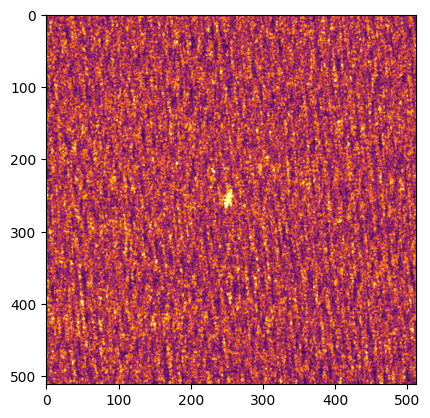

In [33]:
import matplotlib.pyplot as plt 
plt.imshow(chip, cmap='inferno', vmin=np.nanmean(chip)-3*np.nanstd(chip), vmax=np.nanmean(chip)+3*np.nanstd(chip))

# SLC processing

In [34]:
from pathlib import Path

# ------------------------------------------------------------------
# Inputs you supply
slc_safe = Path(slc_path)
# target_lat, target_lon = 35.1234, -6.4321          # replace with your point of interest
window_size = 512
half = window_size // 2
# ------------------------------------------------------------------

# Instantiate the georeferencer and pick the burst/polarization you want
slc_geo = SLCGeoreferencer(slc_safe)
measurement_entry = slc_geo.list_measurements()[0]  # or pick by stem/polarization

with slc_geo.open_measurement(measurement_entry) as slc_ds:
    # Full-scene geolocation to locate the closest pixel
    lat_grid, lon_grid = slc_geo.compute_lat_lon(measurement_entry, dtype=np.float64)

    dist = (lat_grid - target_lat) ** 2 + (lon_grid - target_lon) ** 2
    row, col = np.unravel_index(int(np.argmin(dist)), dist.shape)

    window = Window(col - half, row - half, window_size, window_size)
    window = window.round_offsets().round_lengths()
    window = window.intersection(Window(0, 0, slc_ds.width, slc_ds.height))

    # Grab the complex data (no calibration applied)
    complex_chip = slc_ds.read(1, window=window)        # dtype should be complex64
    lat_chip, lon_chip = slc_geo.compute_lat_lon(measurement_entry, window=window)

# complex_chip -> raw SLC values for the 512×512 tile
# lat_chip / lon_chip -> per-pixel geographic coordinates for the chip


In [39]:
measurement_entry = slc_geo.list_measurements()[0]  # or pick by stem/polarization
measurement_entry

ManifestEntry(href='measurement/s1a-iw1-slc-vh-20201105t183714-20201105t183740-035117-041924-001.tiff', polarization='VH', swath='IW1')

In [35]:
slc_ds.width

21515

In [36]:
slc_ds.height

13464

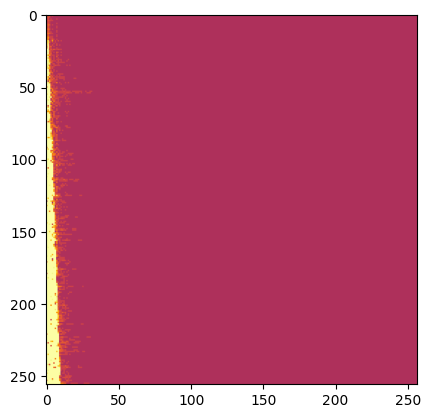

In [37]:
import matplotlib.pyplot as plt 
tobeplot = np.abs(complex_chip)
plt.imshow(tobeplot, cmap='inferno', vmin=np.nanmean(tobeplot)-2*np.nanstd(tobeplot), vmax=np.nanmean(tobeplot)+2*np.nanstd(tobeplot))